In [1]:
import pandas as pd
import numpy as np
import os
import sys
import random
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio
import warnings
from google.colab import drive

In [2]:
sns.set_theme(style="whitegrid")

In [3]:
if not sys.warnoptions:
  warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
parent_folder = '/content/drive/MyDrive/Colab Notebooks/Audio Classification/Feature Engineering'

In [6]:
data_path = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Audio Classification/Dataset/Final Path File/final_path.csv')

In [7]:
def create_waveplot(data, sr, e):
  plt.figure(figsize=(10, 3))
  plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
  librosa.display.waveshow(data, sr=sr)
  plt.show()

In [8]:
def create_spectrogram(data, sr, e):
  X = librosa.stft(data)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize=(12, 3))
  plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
  librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
  plt.colorbar()

In [9]:
def noise(data):
  noise_amp = 0.04*np.random.uniform()*np.amax(data)
  data = data + noise_amp*np.random.normal(size=data.shape[0])
  return data

In [10]:
def stretch(data, rate=0.70):
  return librosa.effects.time_stretch(data,rate=rate)

In [11]:
def shift(data):
  shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
  return np.roll(data, shift_range)

In [12]:
def pitch(data, sampling_rate, pitch_factor=0.7):
  return librosa.effects.pitch_shift(data, sr=sampling_rate,
                                     n_steps=pitch_factor)

In [13]:
def higher_speed(data, speed_factor = 1.25):
  return librosa.effects.time_stretch(data,rate=speed_factor)

In [14]:
def lower_speed(data, speed_factor = 0.75):
  return librosa.effects.time_stretch(data,rate=speed_factor)

In [15]:
def _plot_signal_and_augmented_signal(signal, augmented_signal, sr):
  fig, ax = plt.subplots(nrows=2)
  fig.tight_layout(pad = 5)
  librosa.display.waveshow(signal, sr=sr, ax=ax[0])
  ax[0].set(title='Original Signal')
  librosa.display.waveshow(augmented_signal, sr=sr, ax=ax[1])
  ax[1].set(title='Augmented Signal')
  plt.show()

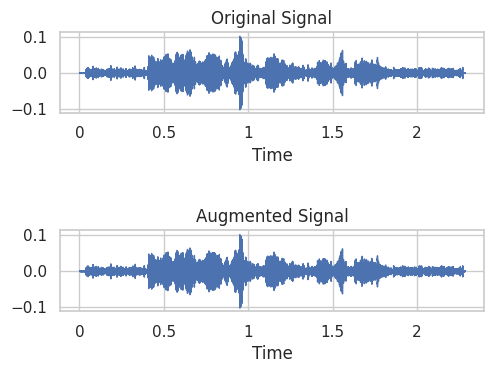

In [16]:
path = np.array(data_path['Path'])[1]
data, sr = librosa.load(path)
augmented_signal = noise(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

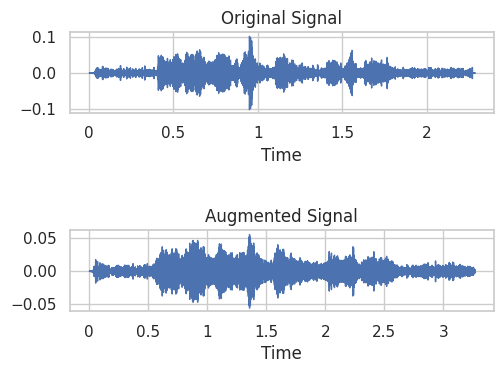

In [17]:
path = np.array(data_path['Path'])[1]
data, sr = librosa.load(path)
augmented_signal = stretch(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

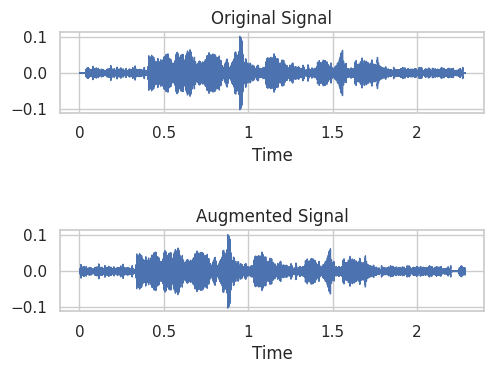

In [18]:
path = np.array(data_path['Path'])[1]
data, sr = librosa.load(path)
augmented_signal = shift(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

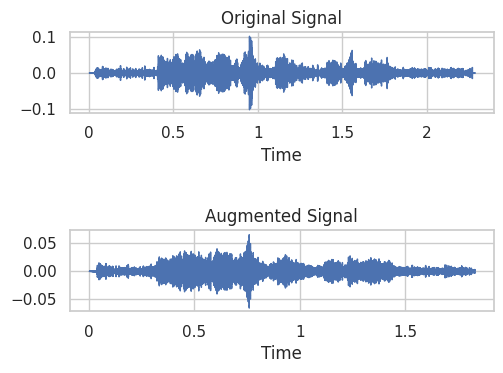

In [19]:
path = np.array(data_path['Path'])[1]
data, sr = librosa.load(path)
augmented_signal = higher_speed(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

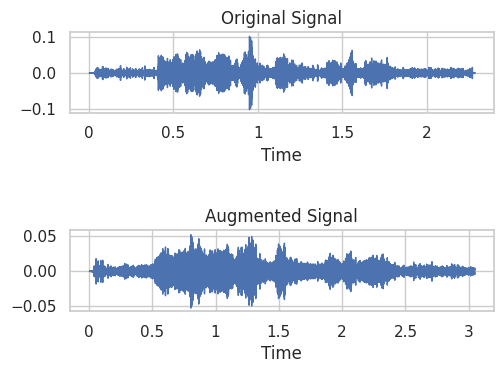

In [20]:
path = np.array(data_path['Path'])[1]
data, sr = librosa.load(path)
augmented_signal = lower_speed(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

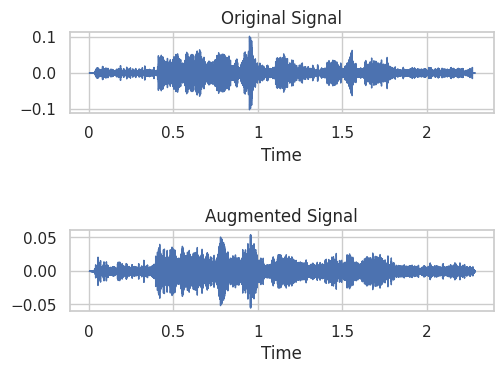

In [21]:
path = np.array(data_path['Path'])[1]
data, sr = librosa.load(path)
augmented_signal = pitch(data,22050)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

In [22]:
Audio(data, rate=sr)

In [23]:
Audio(noise(data), rate=sr)

In [24]:
Audio(shift(data), rate=sr)

In [25]:
Audio(stretch(data), rate=sr)

In [26]:
Audio(lower_speed(data), rate=sr)

In [27]:
Audio(higher_speed(data), rate=sr)

In [28]:
Audio(pitch(data,22050), rate=sr)

In [29]:
def extract_features(data):
  result = np.array([])
  mfccs = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=58)
  mfccs_processed = np.mean(mfccs.T,axis=0)
  result = np.array(mfccs_processed)
  return result

In [30]:
def get_features(path):
  data, sample_rate = librosa.load(path, duration=3, offset=0.5)
  res1 = extract_features(data)
  result = np.array(res1)
  noise_data = noise(data)
  res2 = extract_features(noise_data)
  result = np.vstack((result, res2))
  stretch_data = stretch(data)
  res3 = extract_features(stretch_data)
  result = np.vstack((result, res3))
  shift_data = shift(data)
  res4 = extract_features(shift_data)
  result = np.vstack((result, res4))
  pitch_data = pitch(data, sample_rate)
  res5 = extract_features(pitch_data)
  result = np.vstack((result, res5))
  higher_speed_data = higher_speed(data)
  res6 = extract_features(higher_speed_data)
  result = np.vstack((result, res6))
  lower_speed_data = higher_speed(data)
  res7 = extract_features(lower_speed_data)
  result = np.vstack((result, res7))
  return result

In [31]:
if 'features.csv' not in set(os.listdir(parent_folder)):
  X, Y = [], []
  for path, emotion in zip(data_path['Path'], data_path['Emotion']):
    features = get_features(path)
    for feature in features:
      X.append(feature)
      Y.append(emotion)
  print(len(X), len(Y), data_path['Path'].shape)
  Features = pd.DataFrame(X)
  Features['Emotion'] = Y
  Features.to_csv(parent_folder + 'features.csv', index=False)